<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lvm/ae_mnist_2d_gdl_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder on mnist using 2d latent space

We fit the model to MNIST and use a 2d latent space.
Code is based on chapter 3 of David Foster's book:
https://github.com/davidADSP/GDL_code/.
We have added all the necessary libraries into a single notebook.
We have modified it to work with TF 2.0.




In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

TensorFlow 2.x selected.


In [3]:
#https://github.com/davidADSP/GDL_code/blob/master/utils/loaders.py

from tensorflow.keras.datasets import mnist
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)
  
(x_train, y_train), (x_test, y_test) = load_mnist()
print(x_train.shape)


(60000, 28, 28, 1)


In [0]:
# Utility functions
#https://github.com/davidADSP/GDL_code/blob/master/utils/callbacks.py

from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)
                
            
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1
        if False:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()        
            plt.figure()
            if len(reconst.shape) == 2:
                plt.imshow(reconst, cmap='gray')
            else:
                plt.imshow(reconst)
            plt.suptitle('end of epoch {}'.format(self.epoch))
            plt.show()



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)
  


In [0]:
def load_model(model_class, folder):
    
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    model = model_class(*params)

    model.load_weights(os.path.join(folder, 'weights/weights.h5'))

    return model

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

#from utils.callbacks import CustomCallback, step_decay_schedule

import numpy as np
import json
import os
import pickle


class Autoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout = False
        ):

        self.name = 'autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        encoder_output= Dense(self.z_dim, name='encoder_output')(x)

        self.encoder = Model(encoder_input, encoder_output)


        ### THE DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)
                
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL AUTOENCODER
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate):
        self.learning_rate = learning_rate

        optimizer = Adam(lr=learning_rate)

        def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

        self.model.compile(optimizer=optimizer, loss = r_loss)

    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)

        


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    
    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=0)

        callbacks_list = [checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)



In [0]:
#https://github.com/davidADSP/GDL_code/blob/master/03_01_autoencoder_train.ipynb

In [0]:
import os

#from utils.loaders import load_mnist
#from models.AE import Autoencoder

RUN_FOLDER = 'ae_digits'
if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))


In [0]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

MODE =  'build' #'load' #

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [0]:
LEARNING_RATE = 0.001 #0.0005
BATCH_SIZE = 256 #32
INITIAL_EPOCH = 0

AE.compile(LEARNING_RATE)


In [11]:
x_train.shape

(60000, 28, 28, 1)

Train on 5000 samples


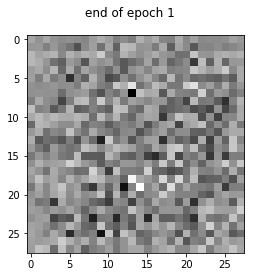

Epoch 1/200
5000/5000 [==============================] - 3s 621us/sample - loss: 0.0791


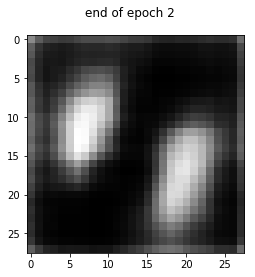

Epoch 2/200
5000/5000 [==============================] - 2s 423us/sample - loss: 0.0550


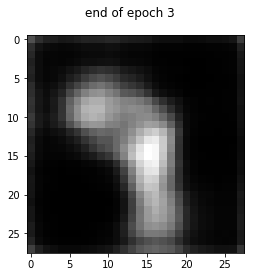

Epoch 3/200
5000/5000 [==============================] - 2s 455us/sample - loss: 0.0524


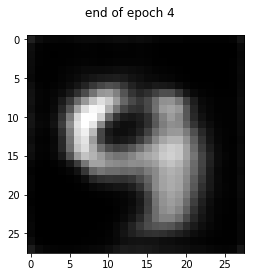

Epoch 4/200
5000/5000 [==============================] - 2s 424us/sample - loss: 0.0506


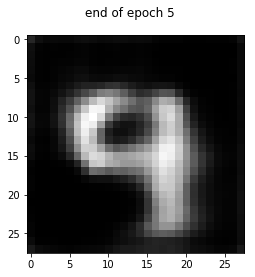

Epoch 5/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0494


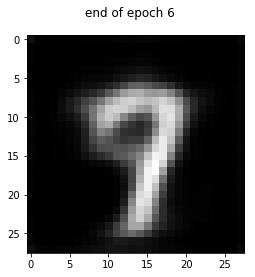

Epoch 6/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0484


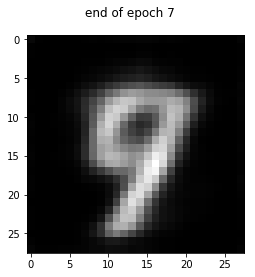

Epoch 7/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0477


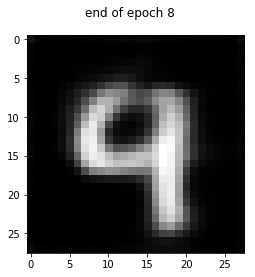

Epoch 8/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0471


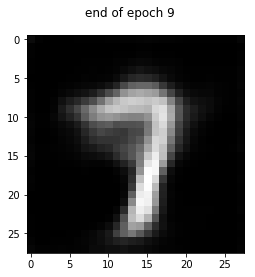

Epoch 9/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0465


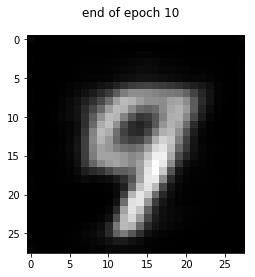

Epoch 10/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0462


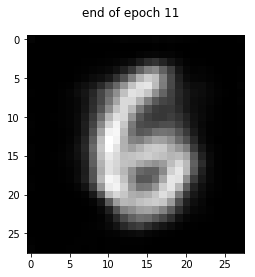

Epoch 11/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0456


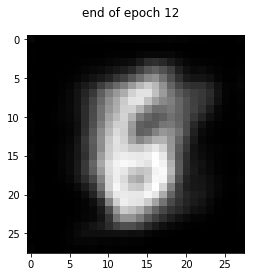

Epoch 12/200
5000/5000 [==============================] - 2s 418us/sample - loss: 0.0452


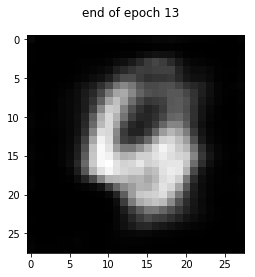

Epoch 13/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0449


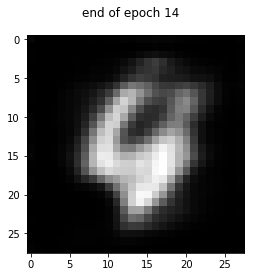

Epoch 14/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0447


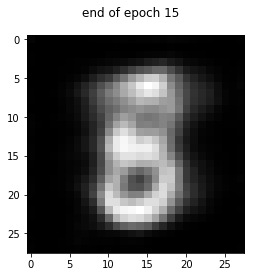

Epoch 15/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0444


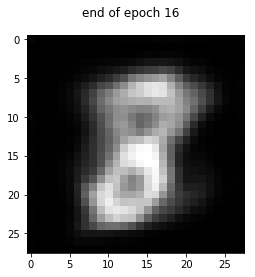

Epoch 16/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0441


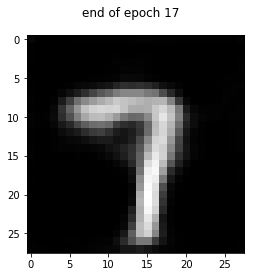

Epoch 17/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0438


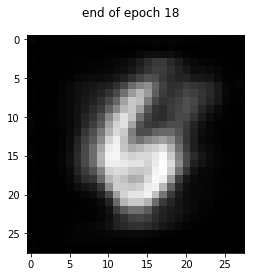

Epoch 18/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0435


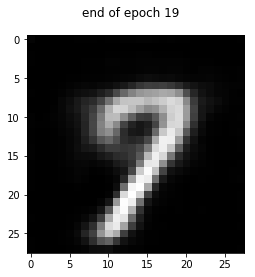

Epoch 19/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0432


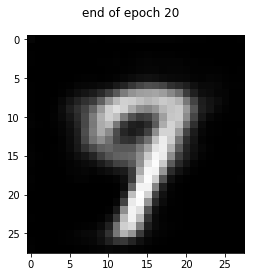

Epoch 20/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0431


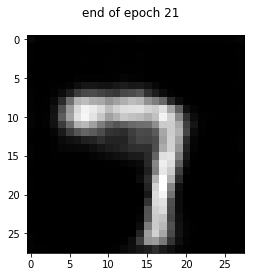

Epoch 21/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0428


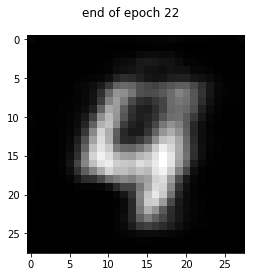

Epoch 22/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0427


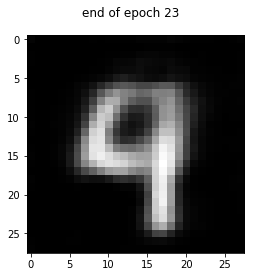

Epoch 23/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0425


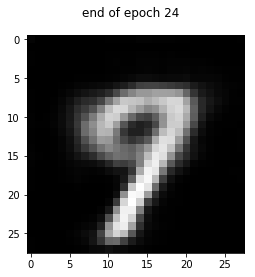

Epoch 24/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0422


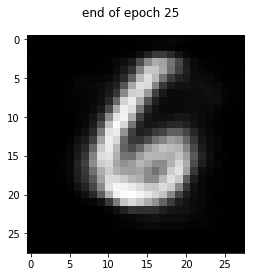

Epoch 25/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0421


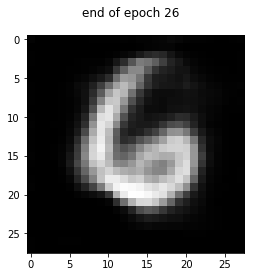

Epoch 26/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0420


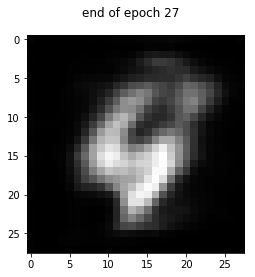

Epoch 27/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0418


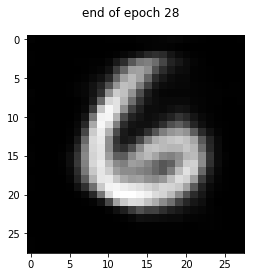

Epoch 28/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0417


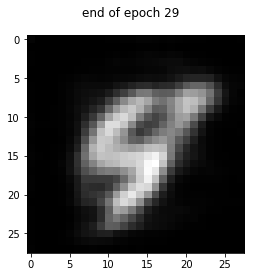

Epoch 29/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0414


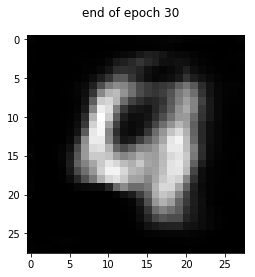

Epoch 30/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0413


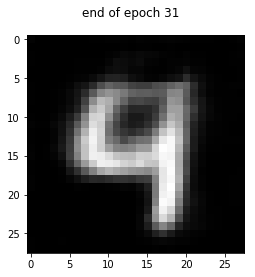

Epoch 31/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0412


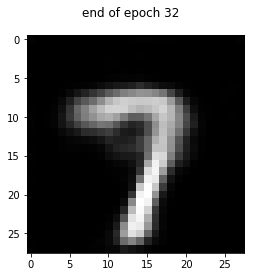

Epoch 32/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0411


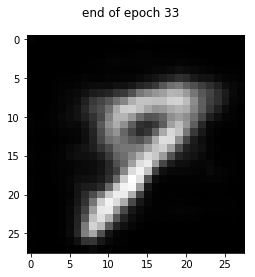

Epoch 33/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0409


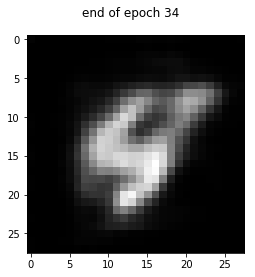

Epoch 34/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0409


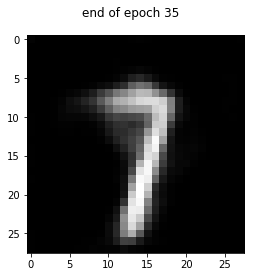

Epoch 35/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0407


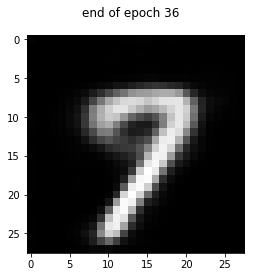

Epoch 36/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0406


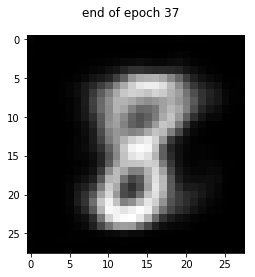

Epoch 37/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0404


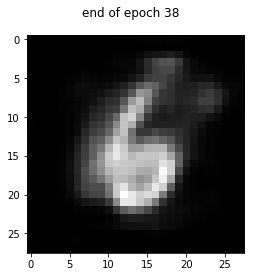

Epoch 38/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0405


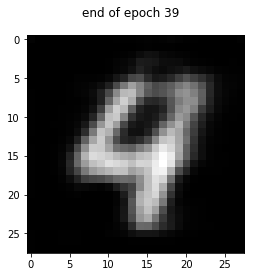

Epoch 39/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0402


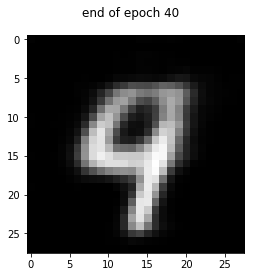

Epoch 40/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0401


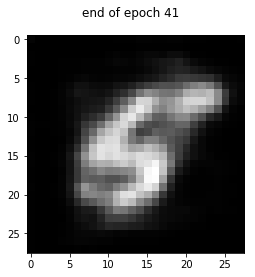

Epoch 41/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0401


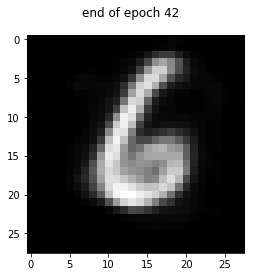

Epoch 42/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0398


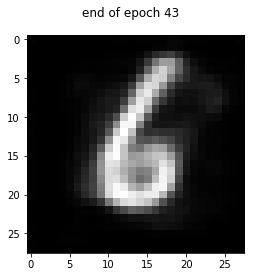

Epoch 43/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0397


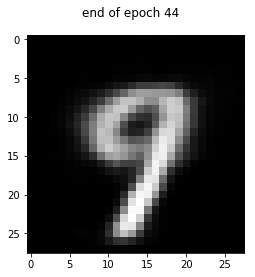

Epoch 44/200
5000/5000 [==============================] - 2s 419us/sample - loss: 0.0396


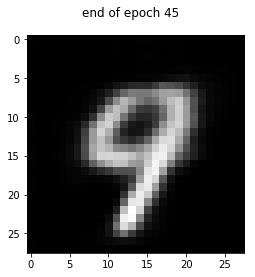

Epoch 45/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0395


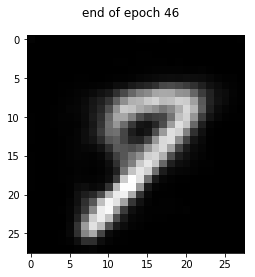

Epoch 46/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0393


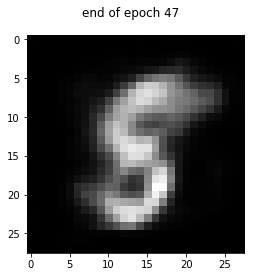

Epoch 47/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0396


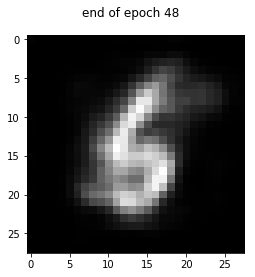

Epoch 48/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0393


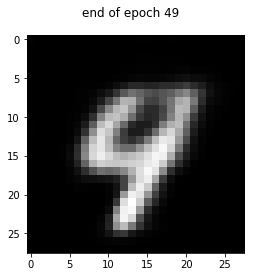

Epoch 49/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0389


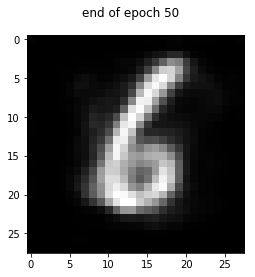

Epoch 50/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0390


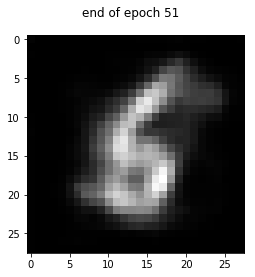

Epoch 51/200
5000/5000 [==============================] - 2s 454us/sample - loss: 0.0389


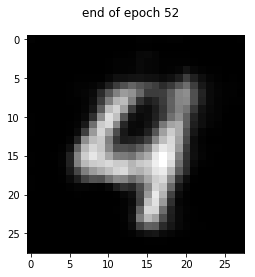

Epoch 52/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0390


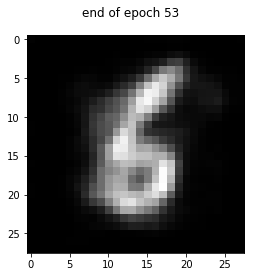

Epoch 53/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0387


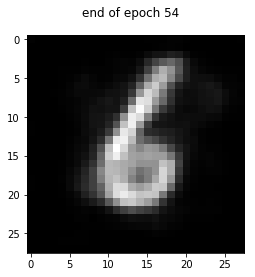

Epoch 54/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0387


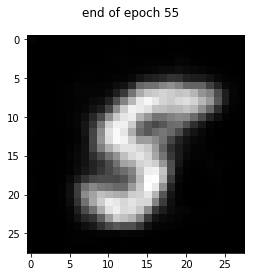

Epoch 55/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0387


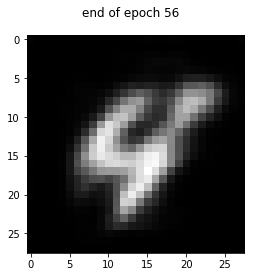

Epoch 56/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0387


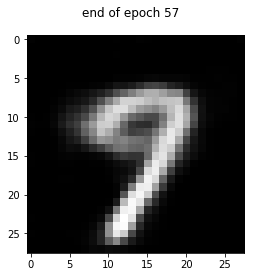

Epoch 57/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0385


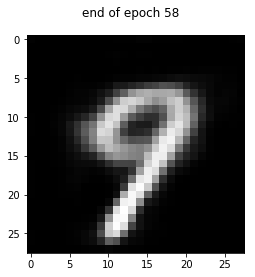

Epoch 58/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0385


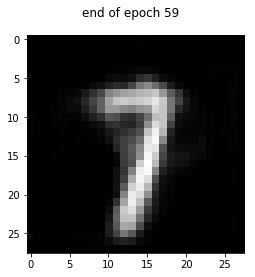

Epoch 59/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0384


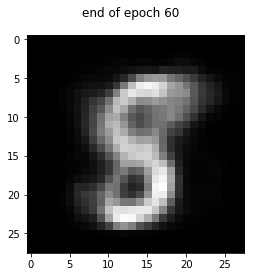

Epoch 60/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0385


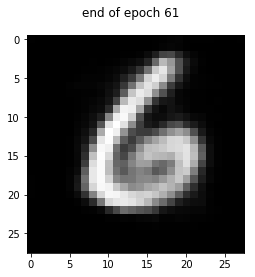

Epoch 61/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0383


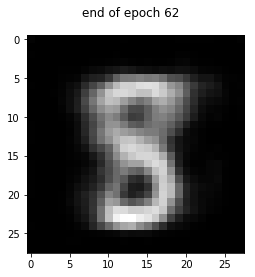

Epoch 62/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0382


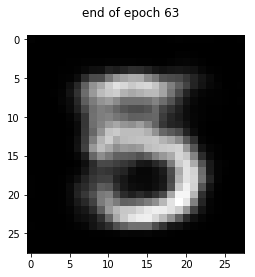

Epoch 63/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0380


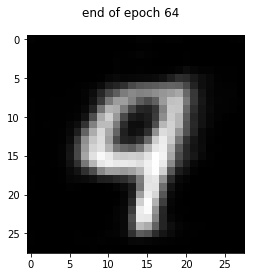

Epoch 64/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0380


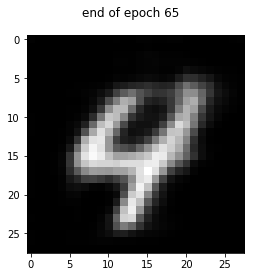

Epoch 65/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0381


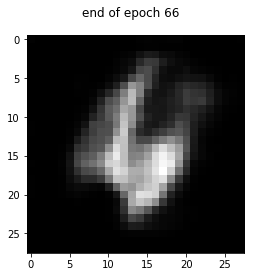

Epoch 66/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0381


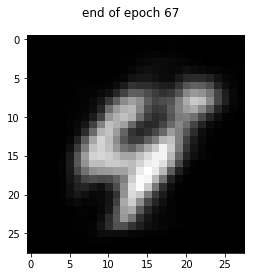

Epoch 67/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0379


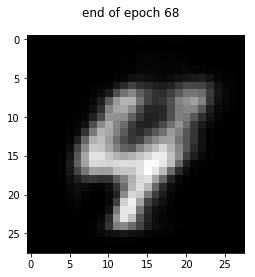

Epoch 68/200
5000/5000 [==============================] - 2s 418us/sample - loss: 0.0376


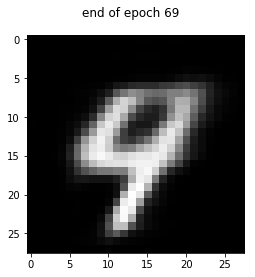

Epoch 69/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0379


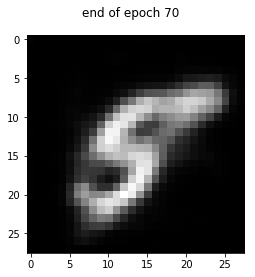

Epoch 70/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0379


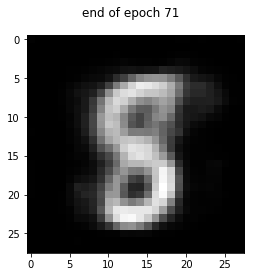

Epoch 71/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0377


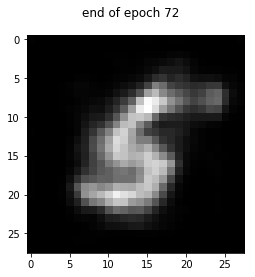

Epoch 72/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0376


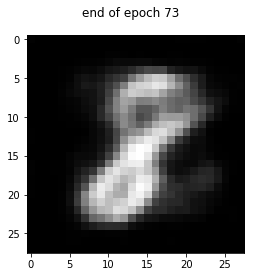

Epoch 73/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0375


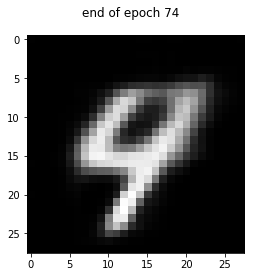

Epoch 74/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0376


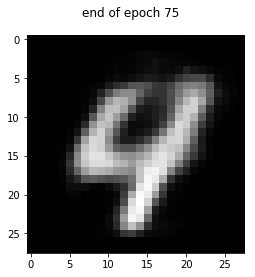

Epoch 75/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0377


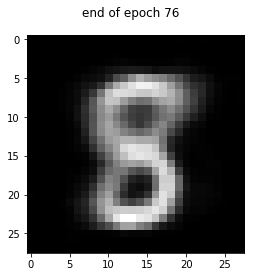

Epoch 76/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0374


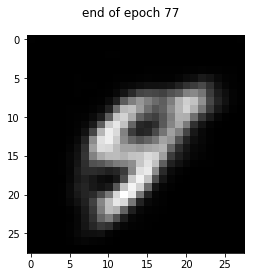

Epoch 77/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0373


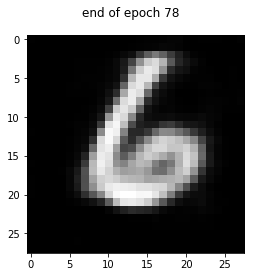

Epoch 78/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0372


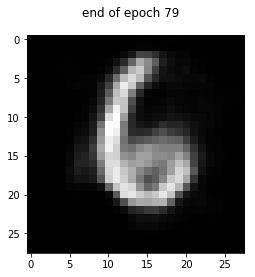

Epoch 79/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0373


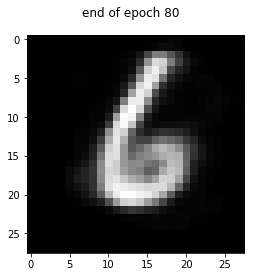

Epoch 80/200
5000/5000 [==============================] - 2s 408us/sample - loss: 0.0373


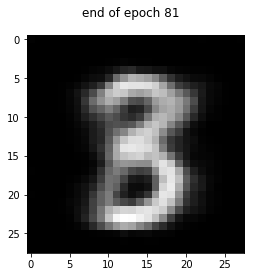

Epoch 81/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0372


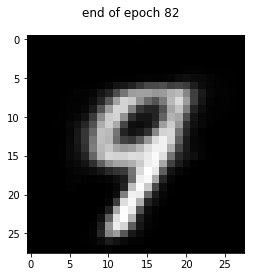

Epoch 82/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0371


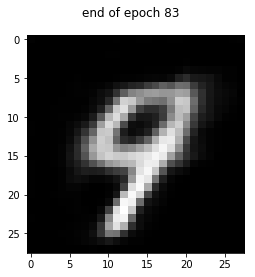

Epoch 83/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0372


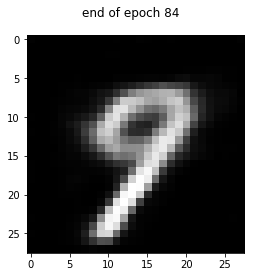

Epoch 84/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0372


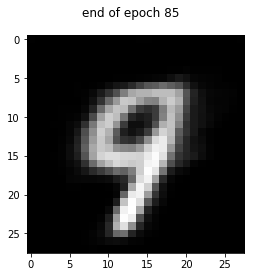

Epoch 85/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0371


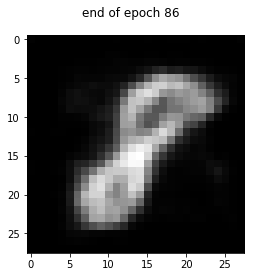

Epoch 86/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0373


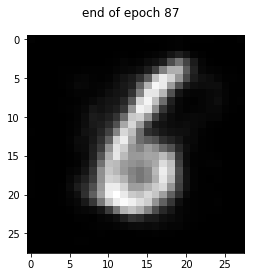

Epoch 87/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0369


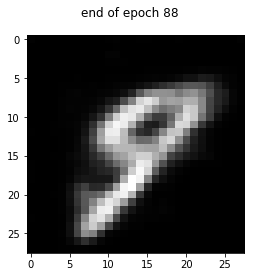

Epoch 88/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0370


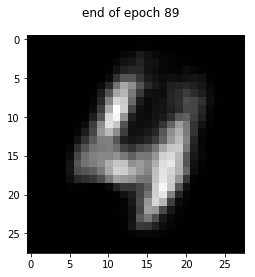

Epoch 89/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0367


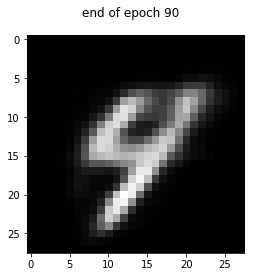

Epoch 90/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0367


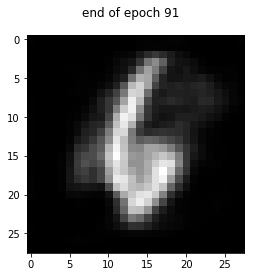

Epoch 91/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0367


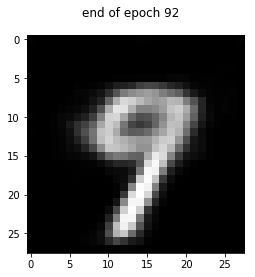

Epoch 92/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0369


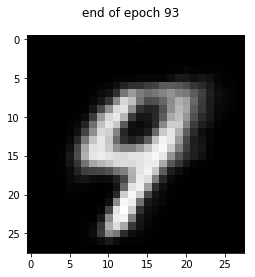

Epoch 93/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0366


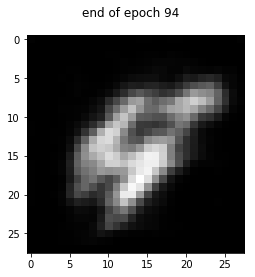

Epoch 94/200
5000/5000 [==============================] - 2s 418us/sample - loss: 0.0367


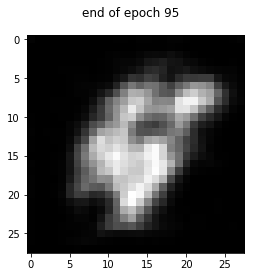

Epoch 95/200
5000/5000 [==============================] - 2s 420us/sample - loss: 0.0370


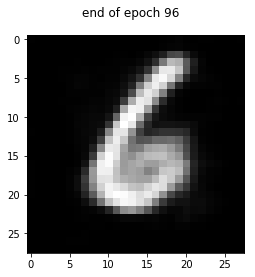

Epoch 96/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0367


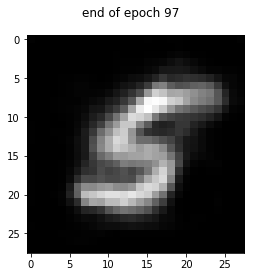

Epoch 97/200
5000/5000 [==============================] - 2s 408us/sample - loss: 0.0367


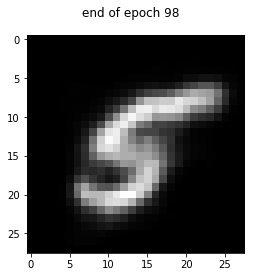

Epoch 98/200
5000/5000 [==============================] - 2s 404us/sample - loss: 0.0366


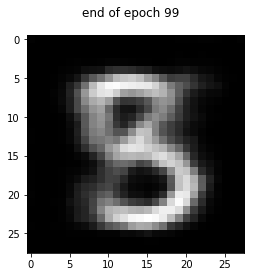

Epoch 99/200
5000/5000 [==============================] - 2s 458us/sample - loss: 0.0367


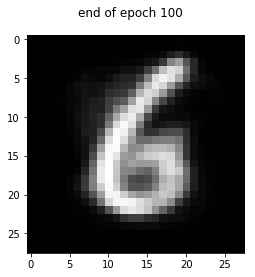

Epoch 100/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0367


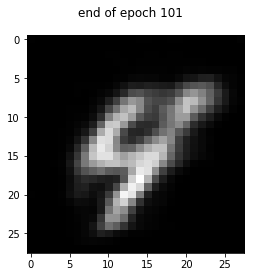

Epoch 101/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0364


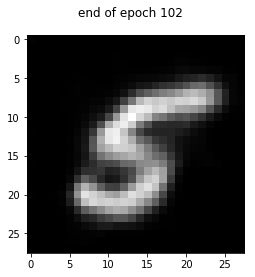

Epoch 102/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0362


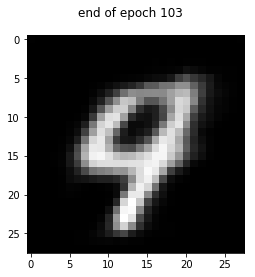

Epoch 103/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0364


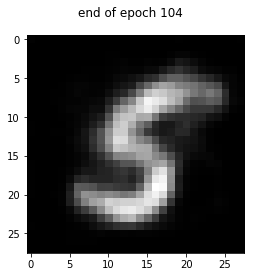

Epoch 104/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0364


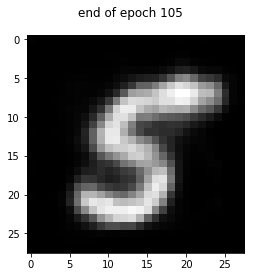

Epoch 105/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0362


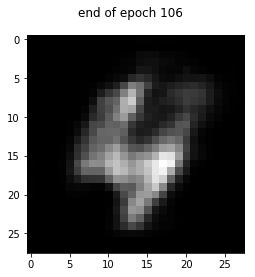

Epoch 106/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0363


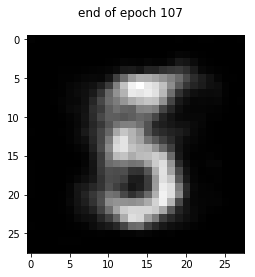

Epoch 107/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0365


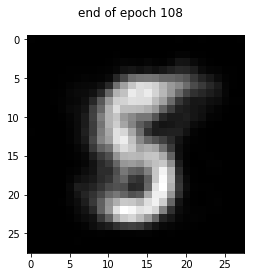

Epoch 108/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0365


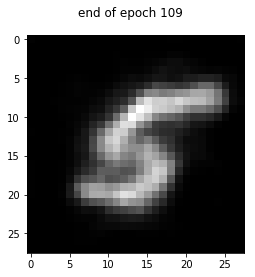

Epoch 109/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0359


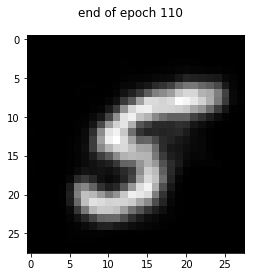

Epoch 110/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0362


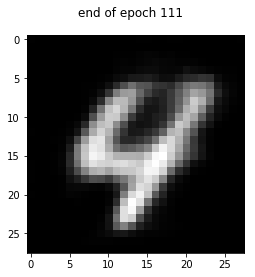

Epoch 111/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0360


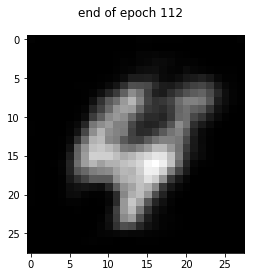

Epoch 112/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0361


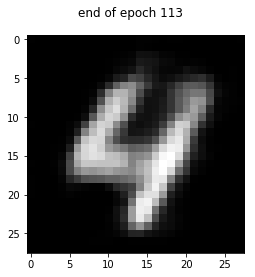

Epoch 113/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0366


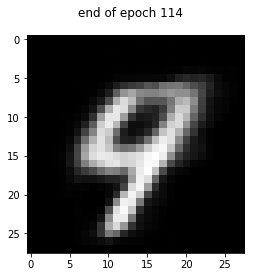

Epoch 114/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0361


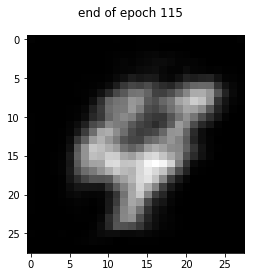

Epoch 115/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0363


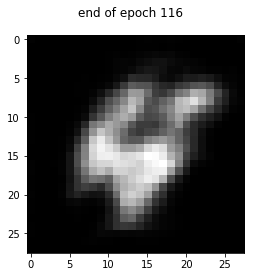

Epoch 116/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0361


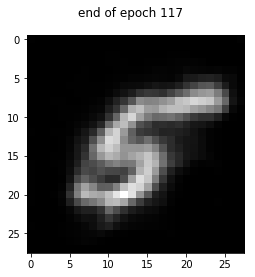

Epoch 117/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0360


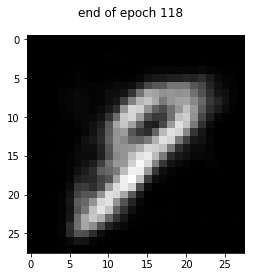

Epoch 118/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0361


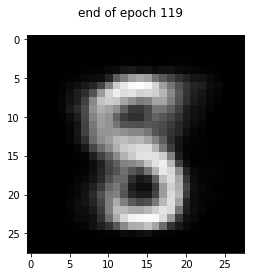

Epoch 119/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0359


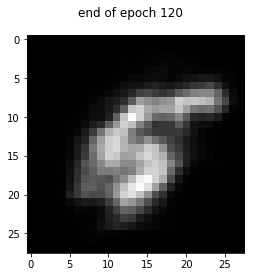

Epoch 120/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0361


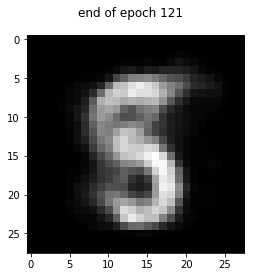

Epoch 121/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0358


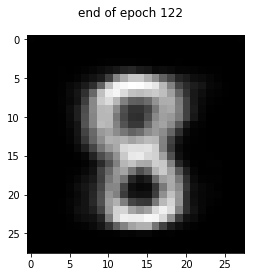

Epoch 122/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0357


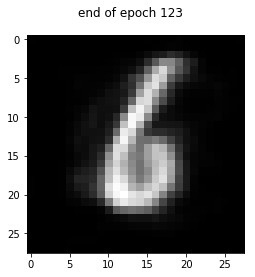

Epoch 123/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0357


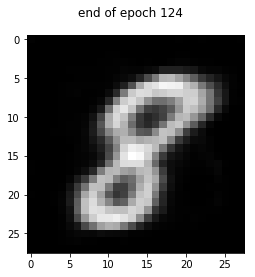

Epoch 124/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0359


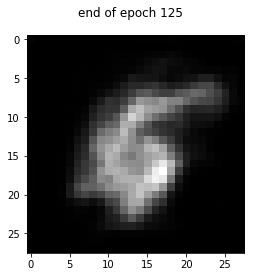

Epoch 125/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0357


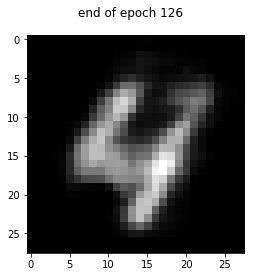

Epoch 126/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0358


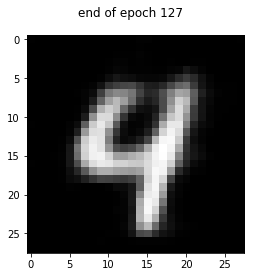

Epoch 127/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0358


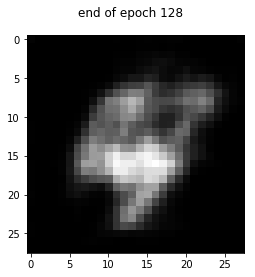

Epoch 128/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0358


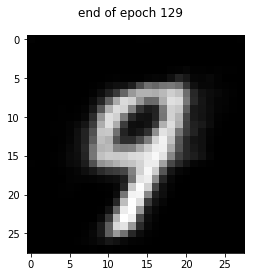

Epoch 129/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0360


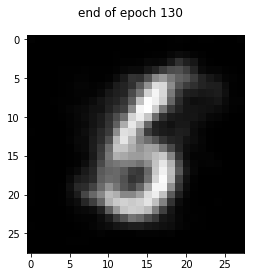

Epoch 130/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0357


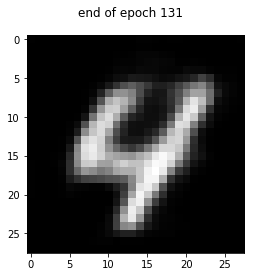

Epoch 131/200
5000/5000 [==============================] - 2s 407us/sample - loss: 0.0357


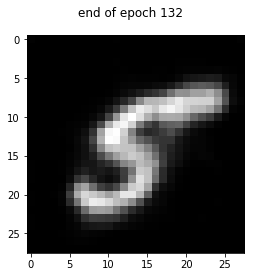

Epoch 132/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0358


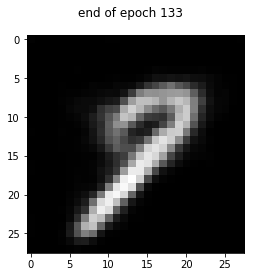

Epoch 133/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0357


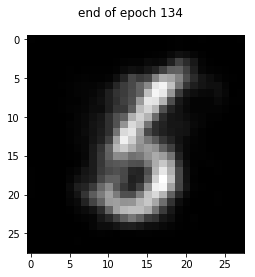

Epoch 134/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0356


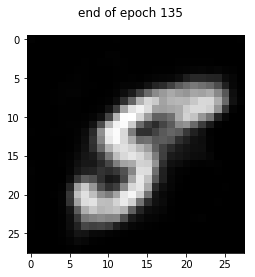

Epoch 135/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0357


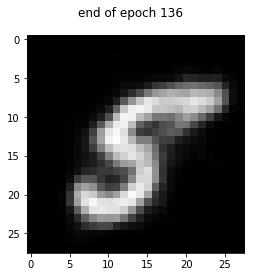

Epoch 136/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0357


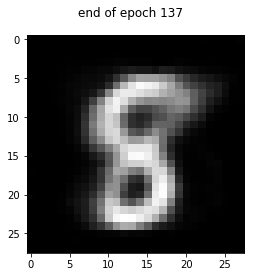

Epoch 137/200
5000/5000 [==============================] - 2s 418us/sample - loss: 0.0355


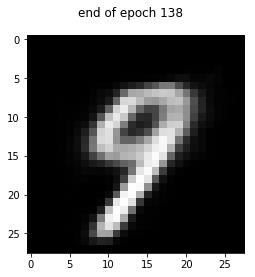

Epoch 138/200
5000/5000 [==============================] - 2s 421us/sample - loss: 0.0355


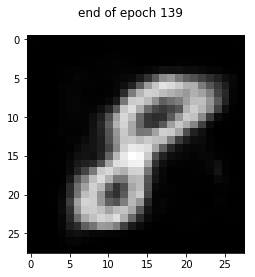

Epoch 139/200
5000/5000 [==============================] - 2s 422us/sample - loss: 0.0358


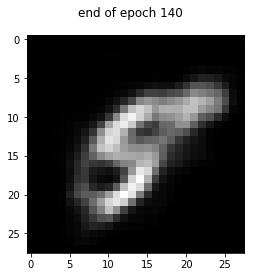

Epoch 140/200
5000/5000 [==============================] - 2s 435us/sample - loss: 0.0357


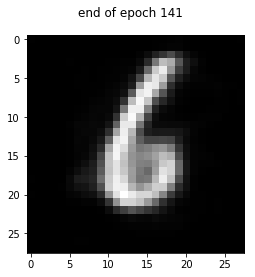

Epoch 141/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0355


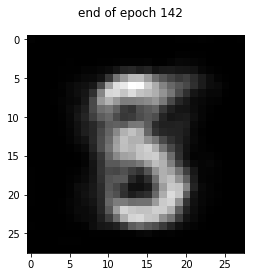

Epoch 142/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0353


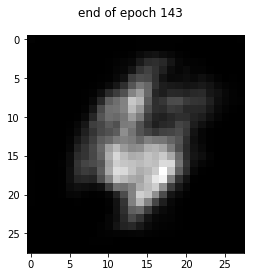

Epoch 143/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0356


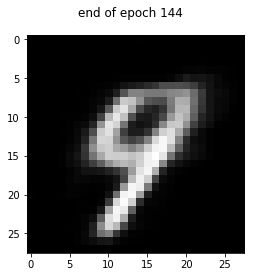

Epoch 144/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0355


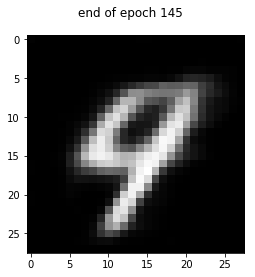

Epoch 145/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0356


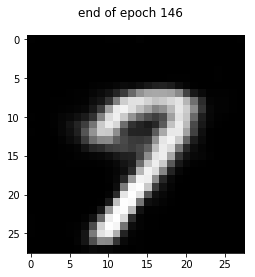

Epoch 146/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0355


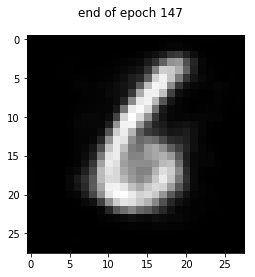

Epoch 147/200
5000/5000 [==============================] - 2s 459us/sample - loss: 0.0355


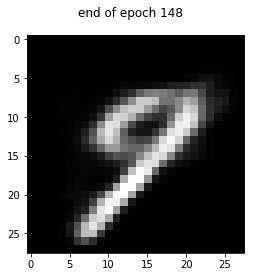

Epoch 148/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0353


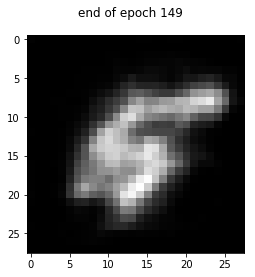

Epoch 149/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0352


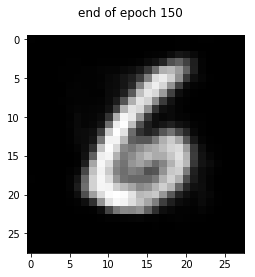

Epoch 150/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0354


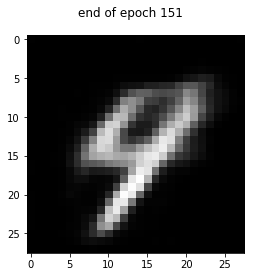

Epoch 151/200
5000/5000 [==============================] - 2s 420us/sample - loss: 0.0353


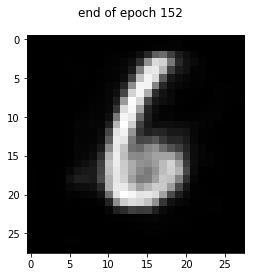

Epoch 152/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0353


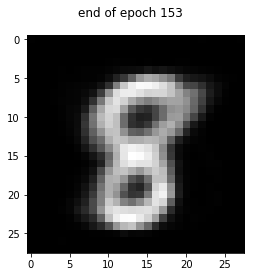

Epoch 153/200
5000/5000 [==============================] - 2s 407us/sample - loss: 0.0352


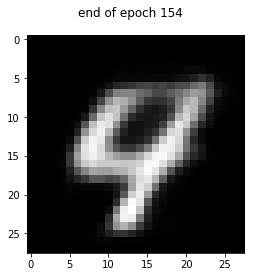

Epoch 154/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0353


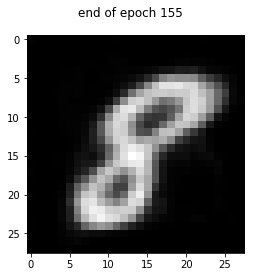

Epoch 155/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0354


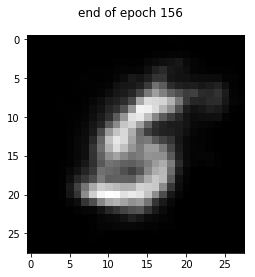

Epoch 156/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0352


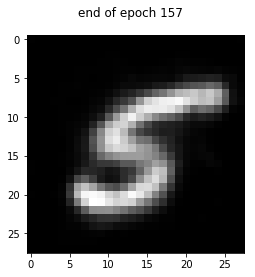

Epoch 157/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0354


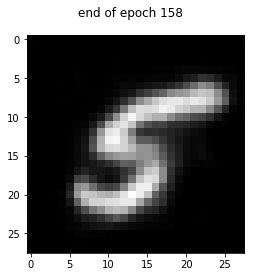

Epoch 158/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0353


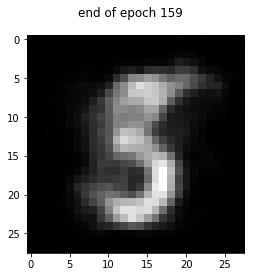

Epoch 159/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0353


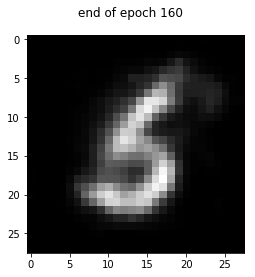

Epoch 160/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0350


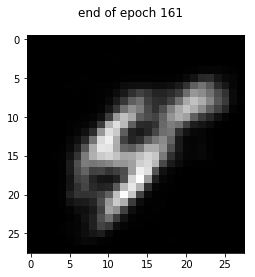

Epoch 161/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0352


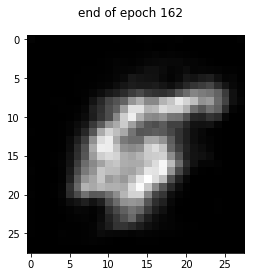

Epoch 162/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0352


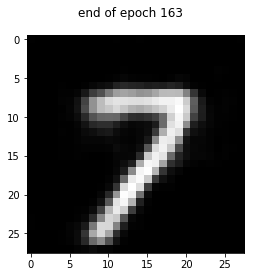

Epoch 163/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0352


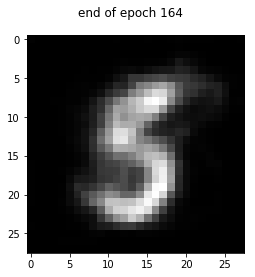

Epoch 164/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0351


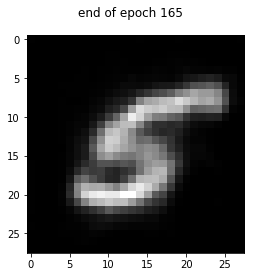

Epoch 165/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0349


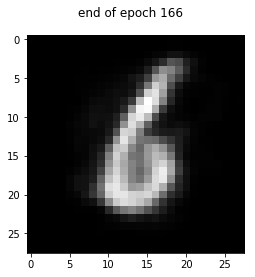

Epoch 166/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0353


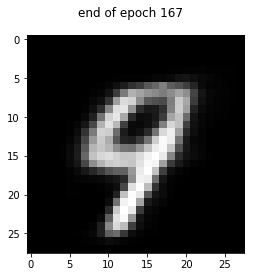

Epoch 167/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0352


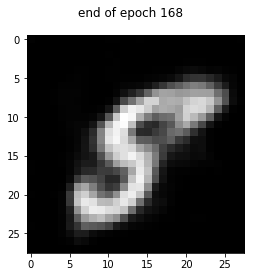

Epoch 168/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0355


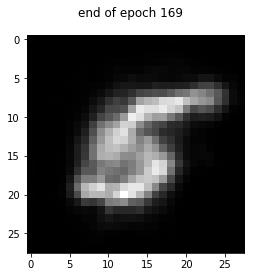

Epoch 169/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0353


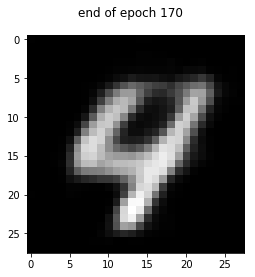

Epoch 170/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0350


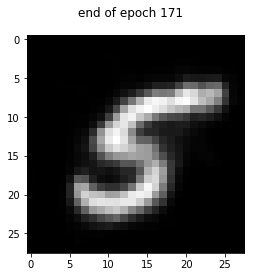

Epoch 171/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0349


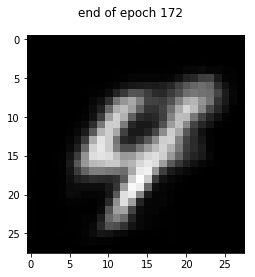

Epoch 172/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0350


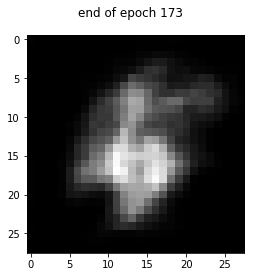

Epoch 173/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0352


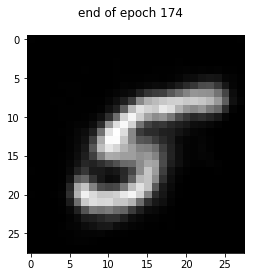

Epoch 174/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0349


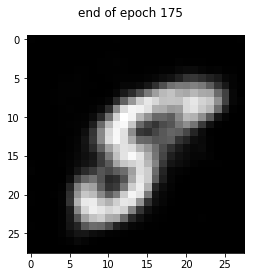

Epoch 175/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0350


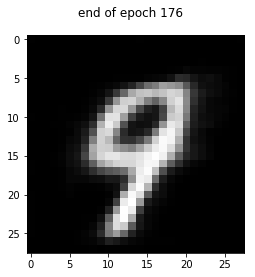

Epoch 176/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0351


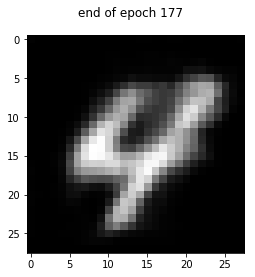

Epoch 177/200
5000/5000 [==============================] - 2s 418us/sample - loss: 0.0350


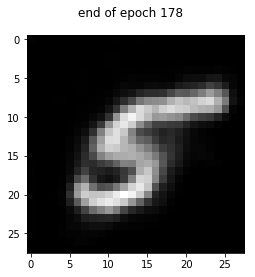

Epoch 178/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0351


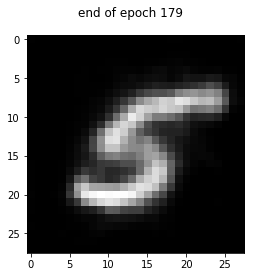

Epoch 179/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0351


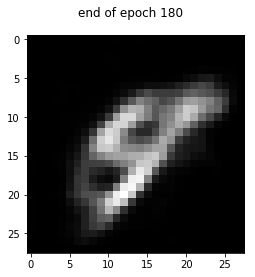

Epoch 180/200
5000/5000 [==============================] - 2s 406us/sample - loss: 0.0351


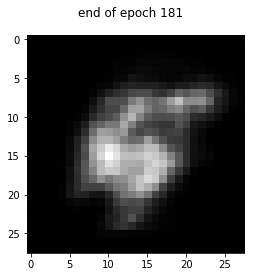

Epoch 181/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0351


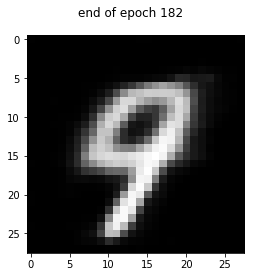

Epoch 182/200
5000/5000 [==============================] - 2s 409us/sample - loss: 0.0347


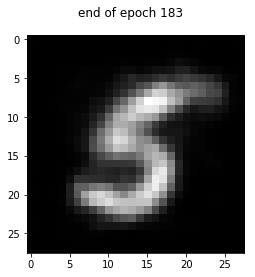

Epoch 183/200
5000/5000 [==============================] - 2s 408us/sample - loss: 0.0349


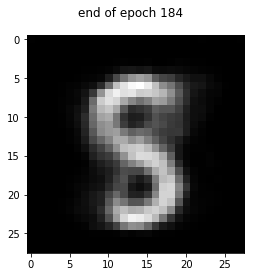

Epoch 184/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0351


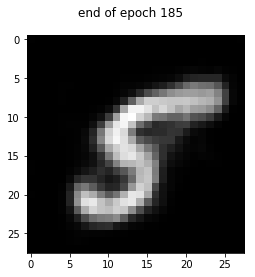

Epoch 185/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0349


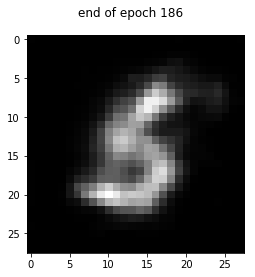

Epoch 186/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0348


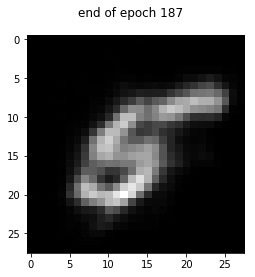

Epoch 187/200
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0347


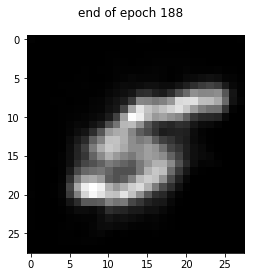

Epoch 188/200
5000/5000 [==============================] - 2s 408us/sample - loss: 0.0349


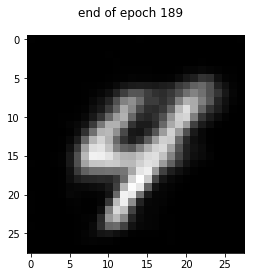

Epoch 189/200
5000/5000 [==============================] - 2s 417us/sample - loss: 0.0350


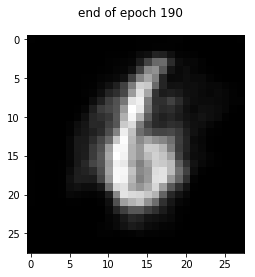

Epoch 190/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0348


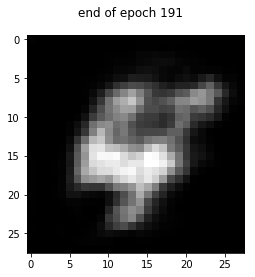

Epoch 191/200
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0347


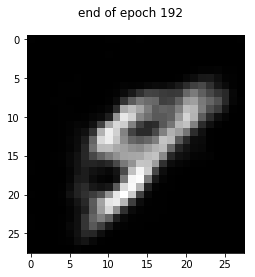

Epoch 192/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0348


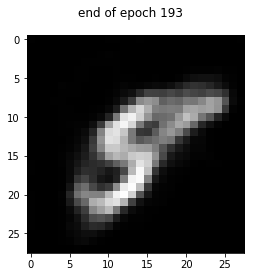

Epoch 193/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0348


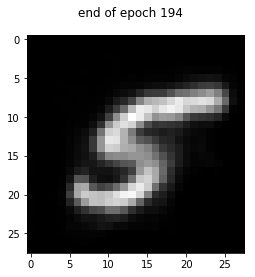

Epoch 194/200
5000/5000 [==============================] - 2s 410us/sample - loss: 0.0350


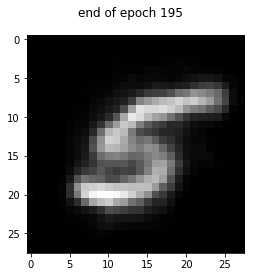

Epoch 195/200
5000/5000 [==============================] - 2s 458us/sample - loss: 0.0348


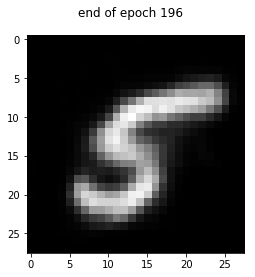

Epoch 196/200
5000/5000 [==============================] - 2s 416us/sample - loss: 0.0347


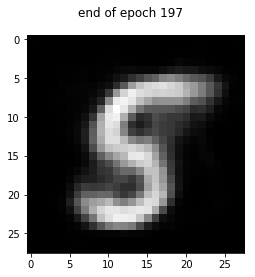

Epoch 197/200
5000/5000 [==============================] - 2s 414us/sample - loss: 0.0346


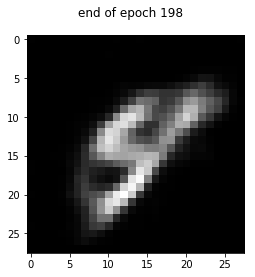

Epoch 198/200
5000/5000 [==============================] - 2s 413us/sample - loss: 0.0346


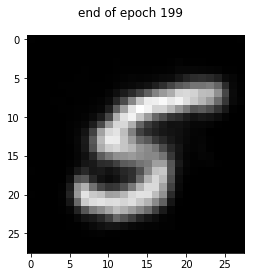

Epoch 199/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0348


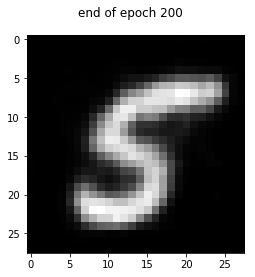

Epoch 200/200
5000/5000 [==============================] - 2s 415us/sample - loss: 0.0348


In [22]:
#N = 20000
N = 5000
EPOCHS = 30

AE.train(     
    x_train[:N]
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
    , print_every_n_batches = 10
)

#def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10, initial_epoch = 0, lr_decay = 1):
  

In [0]:
#https://github.com/davidADSP/GDL_code/blob/master/03_02_autoencoder_analysis.ipynb

In [19]:
!ls ae_digits/weights

weights.h5


In [0]:
AE = load_model(Autoencoder, RUN_FOLDER)

## Reconstruction

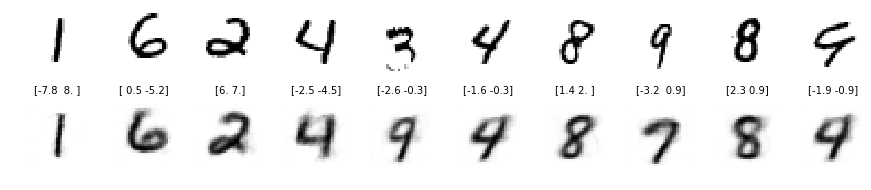

In [26]:
n_to_show = 10
np.random.seed(42)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')
plt.show()

## Generation

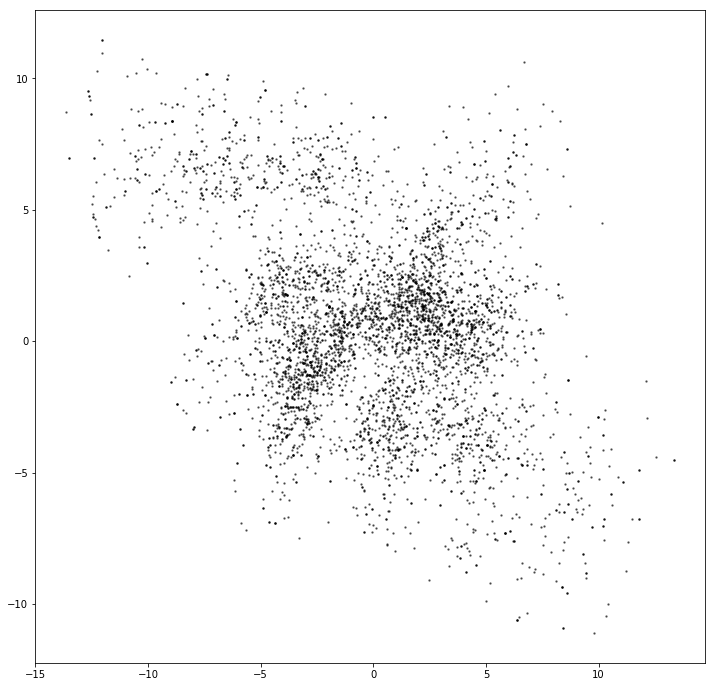

In [27]:
# Show encodings of random images
n_to_show = 5000
grid_size = 15
figsize = 12

np.random.seed(42)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

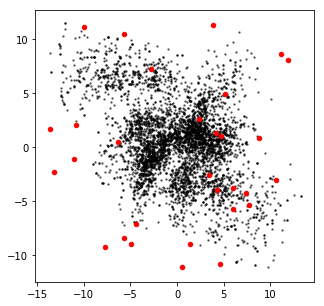

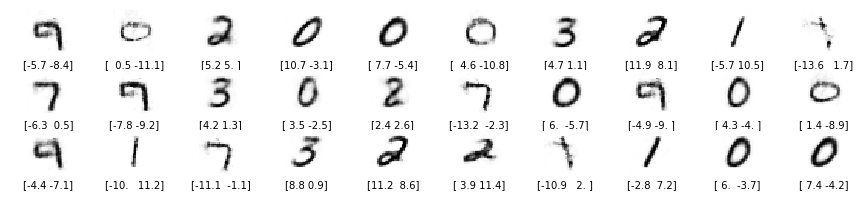

In [28]:
# Generate from random points in latent space

figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

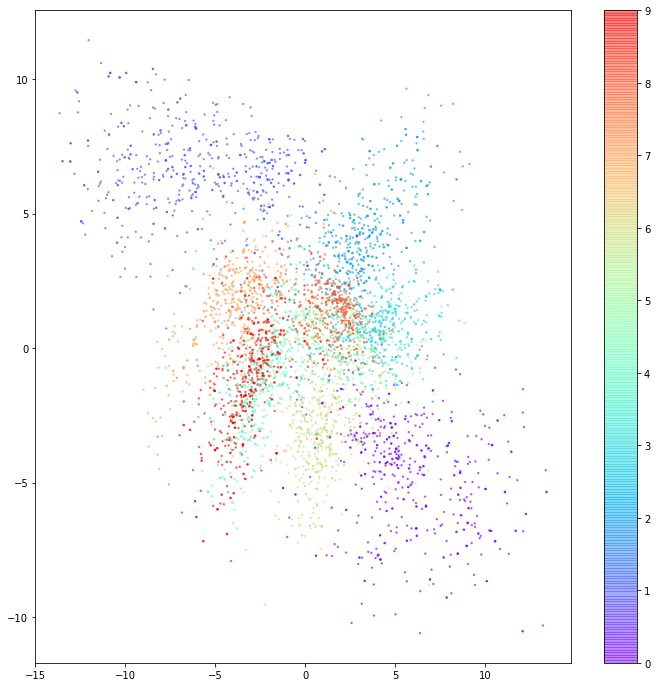

In [29]:
# Color code latent points

n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()


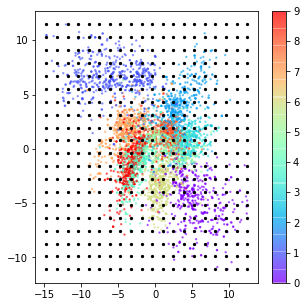

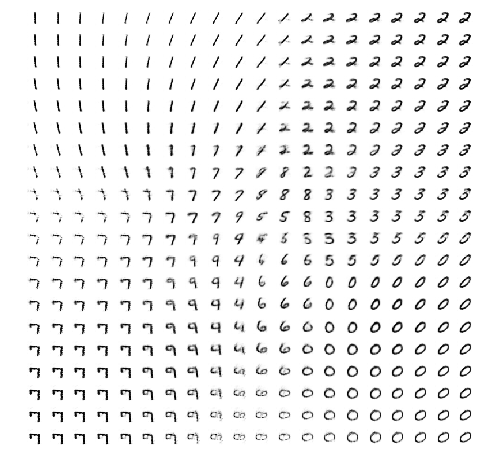

In [30]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')